# The Perceptron Algorithm

This Jupyter Notebook is dedicated to understanding and implementing the perceptron algorithm on soccer data. You can find the dataset [2022-2023 Soccer Player Stats Dataset](https://www.kaggle.com/datasets/vivovinco/20222023-football-player-stats?resource=download).

The following packages are required to run the attached code:

- [Plotly](https://plotly.com/python/)

- [Plotly Express](https://plotly.com/python/plotly-express/)

- [Pandas](https://pandas.pydata.org/docs/)

- [Matplotlib.pylab](https://matplotlib.org/2.0.2/api/pyplot_api.html)

- [Numpy](https://numpy.org/doc/)

- [Seaborn](https://seaborn.pydata.org/)

## Perceptron Explained:

***
The perceptron is a basic building block of artificial intelligence that mimics how a single neuron in the brain works. It takes multiple inputs, each with its own importance (weights), combines them with a bias term, and produces an output. By adjusting the weights and bias based on examples, the perceptron can learn to make decisions or predictions, such as recognizing patterns in data or distinguishing between different classes of objects.

You can see the structure here:

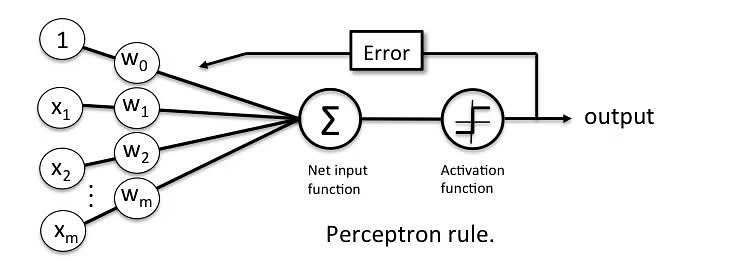

As you can see, there is a single "neuron" that has a bias term (represented by the 1) and data terms that are all weighted. There is then an activation function (normally the step function for perceptron) before retraining the model from the error of the first iteration, which is often called an "epoch."

Image from [SimpliLearn](https://www.simplilearn.com/tutorials/deep-learning-tutorial/perceptron).

***

## Description of the Algorithm:

***
The perceptron algorithm is a fundamental supervised learning algorithm for binary classification tasks. Although the algorithm is simple, it's very effective and an essential part of unsupervised machine learning.

Here is an example of binary classification (specifcally logistic regression, which we will discuss later!):

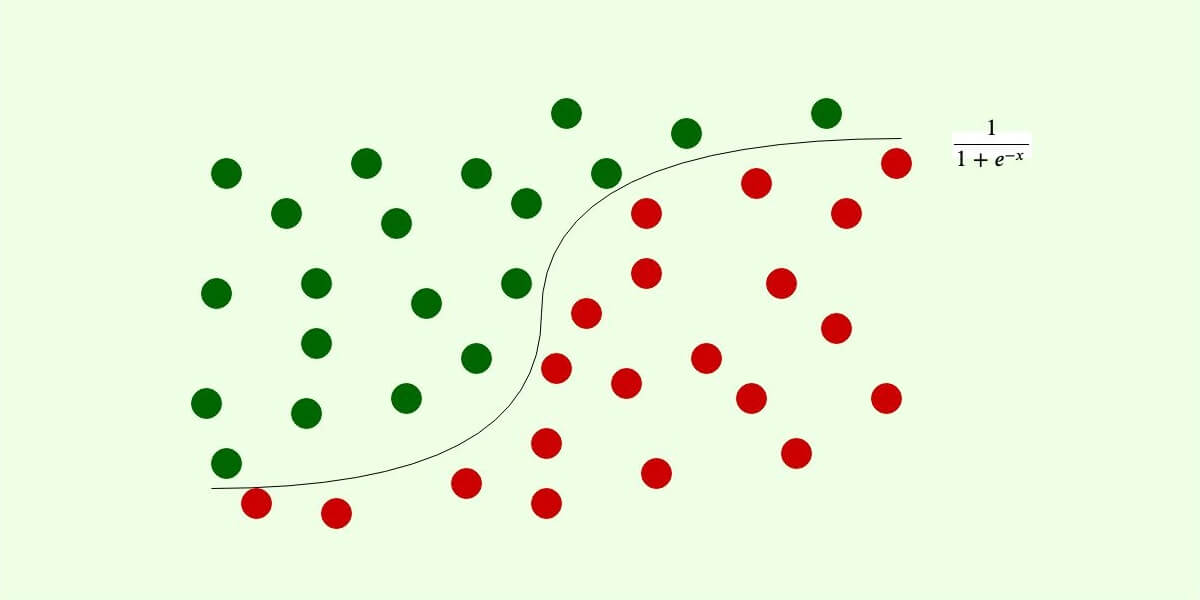

With two classes of data, our goal is to successfully predict which data points belong to each class. 

**Steps:**

1. Initialize Weights and Bias: Start by initializing the weights \( w \) and bias \( b \) to small random values or zeros.

2. Input Features: For each training example \( (x_1, x_2, ..., x_n) \), where \( n \) is the number of features, and its corresponding target label \( y \), do the following:

3. Calculate Linear Combination: Compute the linear combination of the input features and weights, $ z = \sum_{i=1}^{n} w_i \cdot x_i + b $.

4. Activation Function: Apply an activation function (usually a step function) to the linear combination to obtain the predicted class label:

   $
   \hat{y} = \begin{cases}
   1 & \text{if } z \geq 0 \\
   0 & \text{otherwise}
   \end{cases}
   $

5. Update Weights: Update the weights and bias based on the prediction error:
   $
   w_i = w_i + \alpha \cdot (y - \hat{y}) \cdot x_i
   $
   $
   b = b + \alpha \cdot (y - \hat{y})
   $
   where $\alpha$ is the learning rate, a hyperparameter controlling the size of the weight updates.

6. Repeat: Iterate through the training examples for multiple epochs, adjusting the weights and bias after each pass through the dataset.

7. Convergence: The algorithm stops when either all examples are classified correctly or a maximum number of epochs is reached.

The perceptron algorithm is effective for linearly separable datasets but may not converge if the data is not linearly separable.

Image from [AI Geek Programmer](https://manduk.ai/tag/logistic-regression/).
***

## Setting Up:

***
Import the necessary modules and the data.
***

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Import the dataset. 
soccer = pd.read_csv("/Users/pstern/Desktop/INDE-577/Datasets/soccer_stats.csv", encoding='ISO-8859-1', delimiter=';')

***
Get the predictors (Goals, Assists, Passes into the box, and offsides penalties) as well as what we are predicting (Offense or Defense).
***

In [3]:
# Filter the data such that we are only including players who have player more than 15 games worth of time.
data = soccer[soccer['90s'] >= 15.0]

# Just use the first 250 data points.
data = data[:250]

# For simplification, we will only use a few predictors.
predictors = data[['Goals', 'Assists', 'PPA', 'Off', 'ToAtt']]

# Now do the same for the position.
y = data[['Pos']]

# Convert each to a numpy array.
y = y.values
X = predictors.values

***
The perceptron algorithm performs binary classification, so we need to make position binary.
***

In [4]:
# Convert position into a binary variable where -1 is an attacker and 1 is a defender.
# I considered forwards, forward/defenders, and forward/midfielders as attackers.
y = np.where((y == 'FW') | (y == 'FWDF') | (y == 'FWMF') | (y == 'MFFW'), -1, 1)

***
Because the players played different amounts of time, we should also normalize the data.
***

In [5]:
# Get the number of 90s played.
ninetys = data['90s'].values

# Divide each row by the number of 90s played to normalize.
for i in range(X.shape[1]):
    if ninetys[i] != 0:
        X[:, i] = X[:, i] / ninetys[i]


## Implementing the Algorithm:

***
Implement a perceptron class that, for each epoch, makes predictions and calculates the number of errors.
***

In [7]:
class Perceptron(object):
    # Initialize Perceptron object.
    def __init__(self, eta = .5, epochs=50):
        self.eta = eta
        self.epochs = epochs
        
    def train(self, X, y):
        # Initialize random weights.
        self.weight = np.random.rand(1 + X.shape[1])
        self.errors_ = []
        
        # Iterate through the epochs.
        for _ in range(self.epochs):
            errors = 0

            # Iterate through each sample in the training set.
            for xi, target in zip(X, y):

                # Update weights based on the difference between predicted and actual class.
                update = self.eta * (self.predict(xi) - target)
                self.weight[:-1] -= update * xi
                self.weight[-1] -= update

                #Keep track of the number of errors.
                errors += int(update != 0)

            # If there are no errors in this epoch, return.
            if errors == 0:
                return self
            else:
                self.errors_.append(errors)
            
        return self
    
    def net_input(self, X):
        # Calculate net input (sum of weighted inputs plus bias).
        return np.dot(X, self.weight[:-1]) + self.weight[-1]
    
    def predict(self, X):
        # Predict class labels based on net input.
        return np.where(self.net_input(X) >= 0.0, 1, -1)


## Applying the Algorithm:

***
Create an instance of the class to train the model.
***

In [8]:
# Instantiate an instance of the Perceptron class.
ptron = Perceptron(epochs = 500)

# Train the model.
ptron.train(X, y)

***
Make predictions.
***

In [9]:
# Predict make predictions based on training.
y_hat = ptron.predict(X)

# Compare our predictions with reality.
sum = 0
for i in range(len(y_hat)):
    if y_hat[i] == y[i][0]:
        sum += 1

sum / len(y_hat)

0.736

***
Analyze the data.
***

The perceptron model made the correct prediction 90% of the time at 

/Users/pstern/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/pstern/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/pstern/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/pstern/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

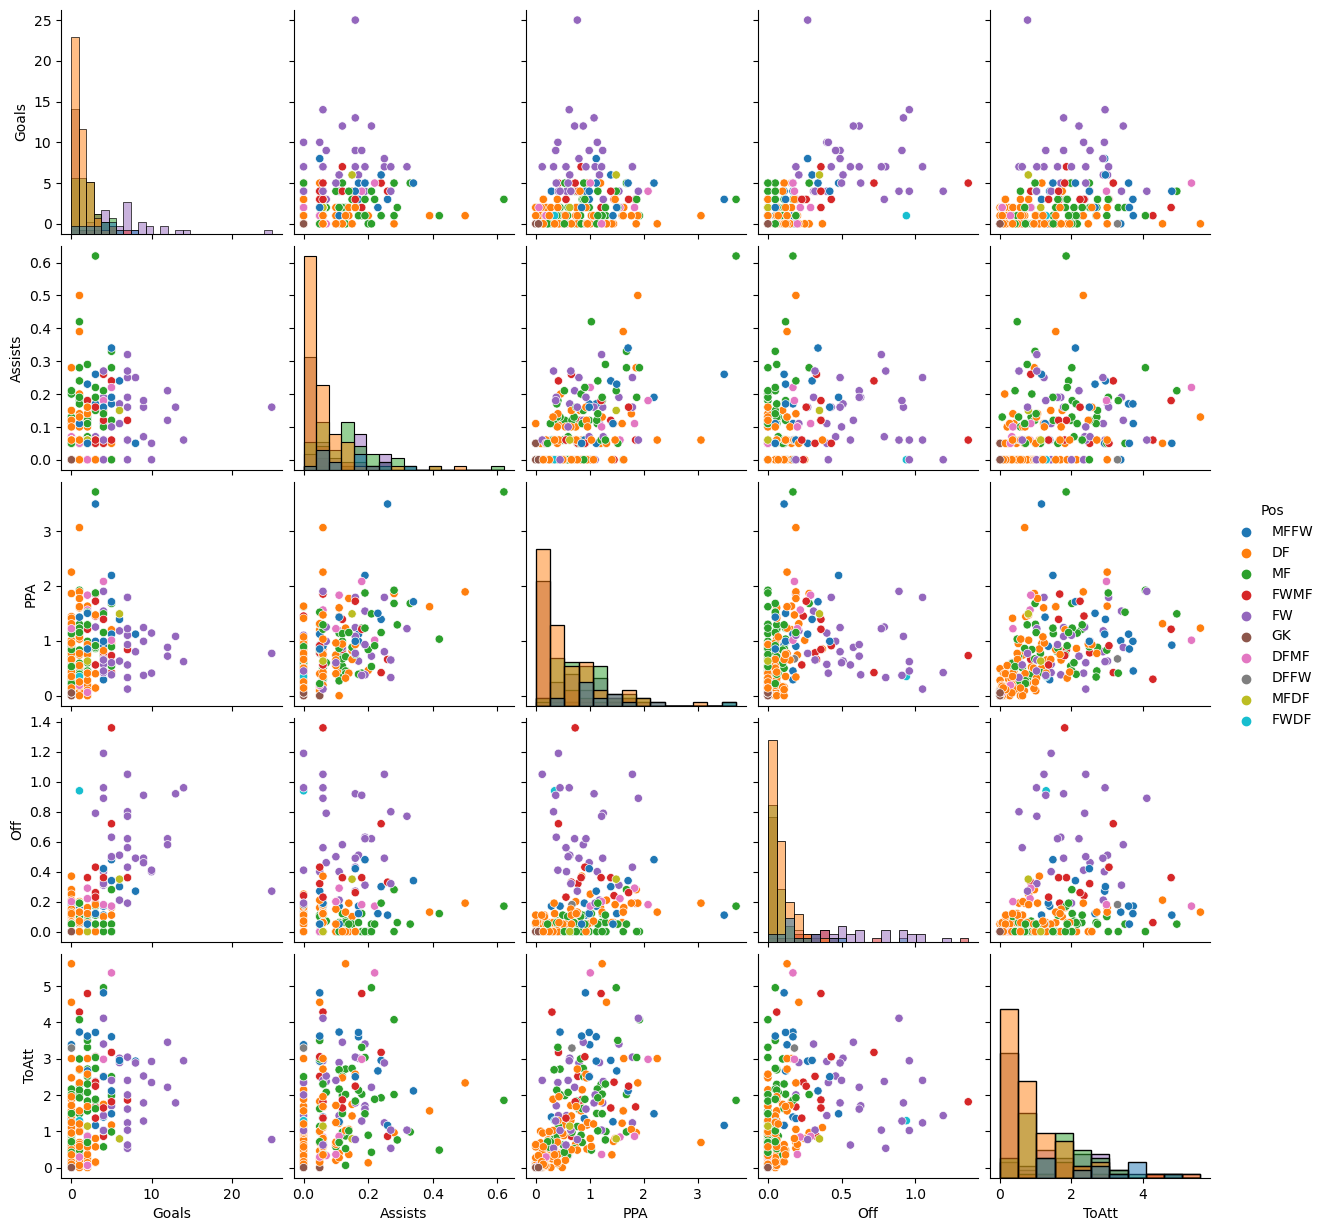

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame containing predictors and target variable
predictors = data[['Goals', 'Assists', 'PPA', 'Off', 'ToAtt']]
y = data['Pos']

# Combine predictors and target into a single DataFrame
df = predictors.copy()
df['Pos'] = y

# Create pairplot
sns.pairplot(df, hue='Pos', diag_kind='hist')
plt.show()
